In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import re
import time
from scipy import stats

import warnings
warnings.filterwarnings("ignore")
import scipy.stats

#Quality of image:
%config InlineBackend.figure_format = 'svg'

pd.set_option('display.max_columns', 100)

In [4]:
def make_metadata(df):
    data = []
    for feature in df.columns:
        # Defining the role
        if feature == 'target':
            role = 'target'
        elif feature == 'id':
            role = 'id'
        else:
            role = 'input'

            
        # Defining the data type 
        dtype = df[feature].dtype

        uniqueCnt = df[feature].nunique()
        
        # Defining the type
        if (df[feature].dtype == 'datetime64[ns]') | (df[feature].dtypes == '<M8[ns]'):
            type = 'datetime'
        elif 'bin' in feature or feature == 'target':
            type = 'binary'
        elif 'cat' in feature or feature == 'id':
            type = 'categorical'
        elif (df[feature].dtype == 'float32') | (df[feature].dtype == 'float64'):
            type = 'numeric'
        elif (df[feature].dtype == 'int32') | (df[feature].dtype == 'int64'):
            type = 'ordinal'
        elif (df[feature].dtype == 'object'):
            type = 'categorical'

        if (uniqueCnt == 2 and type == 'ordinal'):
            type = 'binary'


        # Creating a dictionary for adding a row to metadata:
        feature_dictionary = {
            'varname': feature,
            'role': role,
            'type': type,
            'dtype': dtype,
            'uniqueCnt': uniqueCnt
        }
        data.append(feature_dictionary)

    metadata = pd.DataFrame(data, columns=['varname', 'role', 'type', 'dtype', 'uniqueCnt'])
    metadata.set_index('varname', inplace=True)
    return metadata


def make_typedf(df, metadata, typeName):
    cols = metadata[metadata['type']==typeName].index.tolist()
    if 'id' in cols:
        cols.remove('id')
    
    cnt = len(cols)
    
    res_df = pd.DataFrame(columns={'feature', 'uniqCnt', 'percentage'})
    res_df['feature'] = cols

    uniqLst = [df[col].nunique() for col in cols]
    percentLst = [round(x*100/df.shape[0],2) for x in uniqLst]
    
    res_df['uniqCnt'] = uniqLst
    res_df['percentage'] = percentLst
    res_df.sort_values(by='uniqCnt', inplace=True, ignore_index=True)
    
    # To ensure the order of features in the dataframe:
    res_df = res_df[['feature', 'uniqCnt', 'percentage']]
    return cols, cnt, res_df

def findSeason(dayLst):
    """
    This function gets a list containing day of the year.
    It returns a list of string equivalent to the season for each day in the input list.
    """
    dayofYearLst = df['date'].dt.dayofyear
    seasonLst = ['']*df.shape[0]

    #to divide by season it's better to use the day of the year instead of the months
    springLst = range(80, 172)
    summerLst = range(172, 264)
    fallLst = range(264, 355)
    # winterLst = everything else
    for i, x in enumerate(dayofYearLst):
        if x in springLst:
            season = 'Spring'
        elif x in summerLst:
            season = 'Summer'
        elif x in fallLst:
            season = 'Fall'
        else:
            season = 'Winter'
        seasonLst[i] = season
    return seasonLst

def make_box_plot(df, cols):
    cnt = len(cols)
    if(cnt == 1):
        col = cols[0]
        fig, ax = plt.subplots(figsize=(5,3))
        sns.boxplot(x=df[col], ax=ax);
        #ax.set_title('Distribution')
        ax.set_xlabel(col)
    
    else:
        fig, axes = plt.subplots(cnt, 1, figsize=(5,3*cnt))
        for i, col in enumerate(cols):
            sns.boxplot(x=df[col], ax=axes[i]);
            #axes[i].set_title('Distribution')
            axes[i].set_xlabel(col)
            #axes[i].set_ylabel('Count');
        fig.tight_layout()
    return None

def make_binarybox_plot(df, cols, target, xRotation=0):
    cnt = len(cols)
    if(cnt == 1):
        col = cols[0]
        fig, ax = plt.subplots(figsize=(12,4))
        sns.boxplot(x=df[col], y=df[target], ax=ax);
        ax.set_title('{} Distribution'.format(target))
        ax.set_xlabel(col)
        ax.set_ylabel('{} Range'.format(target));
        if(xRotation != 0):
            ax.tick_params(axis='x', labelrotation=90)

    
    else:
        xCnt = int(np.ceil(cnt/2))
        fig, axes = plt.subplots(xCnt, 2, figsize=(12,4*xCnt))
        for col, ax in zip(cols, axes.flatten()):
            sns.boxplot(x=df[col],y=df[target], ax=ax);
            ax.set_title('{} Distribution'.format(target))
            ax.set_xlabel(col)
            ax.set_ylabel('{} Range'.format(target));
            if(xRotation != 0):
                ax.tick_params(axis='x', labelrotation=90)
            
        fig.tight_layout()
    return None
        
       
def make_bar_plot(x, y,xLabel, yLabel, hue=None, xRotation = 0):
    """
    This function will make a bar plot.
    x: categorical or ordinal List,
    y: Numerical list
    """
    fig, ax = plt.subplots(figsize=(5,3))
    #if (hue != None):
    sns.barplot(x=x, y=y, hue=hue, ax=ax);
    ax.set_title('Distribution')
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel);
    if(xRotation != 0):
        ax.tick_params(axis='x', labelrotation=90)
        
def make_count_plot(df, cols, annotate=False, xRotation = 0, title=None):

    totalcnt = df.shape[0]
    cnt = len(cols)
    if(cnt == 1):
        fig, ax = plt.subplots(figsize=(5,3*cnt))
        col = cols[0]
        sns.countplot(x=df[col], ax=ax);
        ax.set_title(title)
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency');
        

        if(xRotation != 0):
            ax.tick_params(axis='x', labelrotation=90)
            
        if(annotate == True):
                for p in ax.patches:
                    x=p.get_bbox().get_points()[:,0]
                    y=p.get_bbox().get_points()[1,1]
                    ax.annotate('{:.1f}%'.format(y*100/totalcnt), (x.mean(), y), ha='center', va='bottom')

                    
    
    if(cnt>1):
        fig, axes = plt.subplots(cnt, 1, figsize=(5,3*cnt))
        for i, col in enumerate(cols):
            sns.countplot(x=df[col], ax=axes[i]);
            #axes[i].set_title('Distribution')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency');
            
            
            
            if(xRotation != 0):
                axes[i].tick_params(axis='x', labelrotation=90)
            
            if(annotate == True):
                for p in axes[i].patches:
                    x=p.get_bbox().get_points()[:,0]
                    y=p.get_bbox().get_points()[1,1]
                    axes[i].annotate('{:.1f}%'.format(y*100/totalcnt), (x.mean(), y), ha='center', va='bottom')

        fig.tight_layout()
        
        
        
def removeOutliers_IQR(df, num_Feat, nIQR = 1.5, inplace=False ,imputation=0):
    totalCnt = df.shape[0]
    numeric_df = df[num_Feat]
    nonNum_Feat = [col for col in df.columns if col not in num_Feat]
    
    q1 = numeric_df.quantile(.25)
    q3 = numeric_df.quantile(.75)
    iqr = q3 - q1
    lower = (q1 - nIQR * iqr)
    upper = (q3 + nIQR * iqr)
        
#     if(imputation == 0):
#         #new_df = num_df[~((new_df < lower)|(new_df > upper)).any(axis=1)]
#         num_df = num_df[((num_df >lower) & (num_df <upper)).any(axis=1)]
#         final_df = pd.concat([num_df, cat_df], axis=1)
    
    #dropped_df = numeric_df[((numeric_df < lower) | (numeric_df > upper)).any(axis=1)]    
    dropped_df = df.loc[(numeric_df<lower) | (numeric_df>upper)]
    droppedCnt = dropped_df.shape[0]
    droppedPercent = 100 * droppedCnt / totalCnt
    print('\nFor nIQR = {:.2f}'.format(nIQR))
    print('Count of dropped rows: {}'.format(droppedCnt))
    print('Percentage of dropped rows: {:.3f}%'.format(droppedPercent))
    
    #print(numeric_df.loc[dropped_df.index].shape)
    temp_df = df.copy(deep=True)
    temp_df.drop(dropped_df.index, inplace = True)
    if(inplace==True):
        df.drop(dropped_df.index, inplace = True)
    
    return temp_df, dropped_df.index     



def change_datatype(df): #minimize used memory
    for col in list(df.select_dtypes(include=['int']).columns):
        if df[col].max() < 2**7 and df[col].min() >= -2**7:
            df[col] = df[col].astype(np.int8)
        elif df[col].max() < 2**8 and df[col].min() >= 0:
            df[col] = df[col].astype(np.uint8)
        elif df[col].max() < 2**15 and df[col].min() >= -2**15:
            df[col] = df[col].astype(np.int16)
        elif df[col].max() < 2**16 and df[col].min() >= 0:
            df[col] = df[col].astype(np.uint16)
        elif df[col].max() < 2**31 and df[col].min() >= -2**31:
            df[col] = df[col].astype(np.int32)
        elif df[col].max() < 2**32 and df[col].min() >= 0:
            df[col] = df[col].astype(np.uint32)
    for col in list(df.select_dtypes(include=['float']).columns):
        df[col] = df[col].astype(np.float32)
        

def size_MB(obj):
    import sys
    size = sys.getsizeof(obj)
    size /=10**6
    size = round(size, 2)
    return size


def miss_value_func(in_data, classificatio_flag=0, only_miss_col=0):
    """
    The dataframe is supposed to have target column with name of 'target'.
    """
    out_table = pd.DataFrame(in_data.isnull().sum(), columns = ['miss_value'])
    out_table['percentage'] = (100 * out_table['miss_value'])/len(in_data)
    out_table.sort_values(by='miss_value', ascending=False, inplace=True)

    lst_miss_col = [i for i in range(len(out_table)) if (out_table.iloc[i][1]!=0)]    
    print('The input data frame has {:d} features.'.format(in_data.shape[1]))
    print('The data frame has {:d} columns with missing values'.format(len(lst_miss_col)))
    
    
    if(only_miss_col == 1):
        len_miss = len(lst_miss_col)
        out_table = out_table.iloc[:len_miss, :]
    if (classificatio_flag == 0):
        return out_table
    
    if classificatio_flag == 1:
        try:
            uniq_levels = list(in_data['target'].unique())
            uniq_n = len(uniq_levels)
            n_total = len(in_data)
            n_target1 = len(in_data[in_data['target']==1])
            n_target0 = n_total - n_target1
            flag=1
        except:
            print("Error!  The dataframe does not have column with name 'target'.  Try again...")
            flag = 0
        
        if flag == 1:
            
            for lev in uniq_levels:
                str_col = 'count_miss: target=' + str(lev)
                out_table[str_col] = 0 
            
            for lev in uniq_levels:
                str_col = 'percent_miss: target=' + str(lev)
                out_table[str_col] = 0 
                
            for lev in uniq_levels:
                str_col = 'norm_miss: target=' + str(lev)
                out_table[str_col] = 0 
            
            len_miss = len(lst_miss_col)
            for i, col in enumerate(lst_miss_col):
                for j, lev in enumerate(uniq_levels):
                    count = in_data[out_table.index[i]][in_data['target']==lev].to_frame().isnull().sum()
                    percent = (count / out_table.iloc[i, 0])*100
                    out_table.iloc[i, 2+j] = count[0]
                    out_table.iloc[i, 2+j+uniq_n] = percent[0]
                    if(lev == 0):
                        out_table.iloc[i, 2+j+2*uniq_n] = 100*(count[0]/n_target0)
                    elif(lev== 1):
                        out_table.iloc[i, 2+j+2*uniq_n] = 100*(count[0]/n_target1)
            return out_table

        
def add_missCol(df):
    df.reset_index(inplace=True, drop=True)
    length = df.shape[0]
    missLst = [0]*length
    for row in range(length):
        missCnt = 0
        for col in df.columns:
            try:
                x = float(df.loc[row, col])
                if(x!=x):
                    missCnt +=1  
            except:
                pass

            if col == 'count':
                missLst[row] = missCnt
    df['misscnt'] = missLst
    return True#df


def check_numCols(df, cols):
    # This function checks if all columns are numerical or not. 
    # Finally, if there are some columns which are not numerical, they will return.
    resType = [df[col].dtype for col in cols]
    res = [col for i,col in enumerate(cols) if resType[i] == 'O']
    if(len(res)>0):
        print('Notice!!!\n')
        print('The following columns are not pure numerical. They have some non-numericla data.')
        print(res)
    else:
        print('Verified!')
        print('All columns are pure numerical.')
    return df, res

def convert_check_numCols(df, cols, distributionFlag=False):
    # This function will convert passed columns into numerical.
    # Finally, if there are some columns which are remained in form of object datatype, they will return.
    
    # First, we will change datatype into numeric:
    for col in cols:
        df[col] = pd.to_numeric(df[col], errors='ignore')

    
    resType = [df[col].dtype for col in cols]
    catCols = [col for i,col in enumerate(cols) if resType[i] == 'O']# We will save features having nonnumerical data.
    
    if(len(catCols)==0):
        print('All columns are verified; 100% numerical')
        return
    
    elif(len(catCols)>0):        
        print('Notice!!!\n')
        print('The following columns are not pure numerical. They have some non-numericla data.')
        print(catCols)

        # We will save index of data which are not numerical in indexLst.
        indexLst = []
        
        # We keep the info in colLst and rowLst for printing in dataframe.
        colLst = ['Feature', 'NonNumerical %']
        rowLst = []
    
        for col in catCols:
            if(df[col].dtype == 'O'):
                check_status = df[col].apply(lambda x: x.isnumeric())
            else:
                check_status = df[col].apply(lambda x: x.str.isnumeric())
            
            catIndex = check_status.loc[check_status == False].index
            if(len(catIndex>0)):
                indexLst.append(catIndex)
                nonNumericalValue = round(len(catIndex)*100/df.shape[0], 2)
                valueLst = [col, nonNumericalValue]
                dic1 = {k:v for k,v in zip(colLst, valueLst)}
                rowLst.append(dic1)# Will save nonnumerical data for adding into dataframe
                
                if(distributionFlag == True):
                    print('The distribution of nonnumerical data of "{}" is as follow:'.format(col))
                    print(df.loc[catIndex, col].value_counts())
                    print('********************************************************')
        
        res_df = pd.DataFrame(rowLst, columns = colLst)
    return df, catCols, res_df, indexLst


def analyze_prediction(y_predicted, y_observed, result_matrix = None, model_name=None):
    
    rmse = np.sqrt(mean_squared_error(y_true=y_observed, y_pred=y_predicted))
    r2 = r2_score(y_true=y_observed, y_pred=y_predicted)
    
    if (model_name != None):
        result_matrix.loc['R2', model_name] = r2
        result_matrix.loc['RMSE', model_name] = rmse
        

    print("R2, RMSE:")
    return r2, rmse


def makeHeatmap(df, cols, annot = False, line=False):
    #colormap = plt.cm.white
    colormap = plt.cm.YlGnBu
    sns.set(style="whitegrid")


    plt.figure(figsize=(12,10))
    plt.title('Correlation Heatmap', size=15)
    if(line == True):
        sns.heatmap(df[cols].corr(), vmax=1.0, cmap=colormap, annot=annot, square=True, linewidths=0.005, linecolor='gray');
    elif(line == False):
        sns.heatmap(df[cols].corr(), vmax=1.0, cmap=colormap, annot=annot, square=True);

In [ ]:
dataDirectory = os.path.join(os.path.dirname(os.getcwd()),'Spam_Classifier\\data')
imageDirectory = os.path.join(os.path.dirname(os.getcwd()),'Spam_Classifier\\images')

df_original = pd.read_table(dataDirectory + "\\SMSSpamCollection", header=None, names=['label', 'message'])
df_original.head(2)

In [5]:
df = pd.read_csv("D:\my_data\Housing\Melbourne\Melbourne_housing_FULL.csv")

In [6]:
df.shape

(34857, 21)

### Features of the dataset:
**Suburb:** Suburb

**Address:** Address

**Rooms:** Number of rooms

**Price:** Price in Australian dollars

**Method:**
    - S: property sold;
    - SP: property sold prior;
    - PI: property passed in;
    - PN: sold prior not disclosed;
    - SN: sold not disclosed;
    - NB: no bid;
    - VB: vendor bid;
    - W: withdrawn prior to auction;
    - SA: sold after auction;
    - SS: sold after auction price not disclosed.
    - N/A: price or highest bid not available.

**Type:**
    - br: bedroom(s);
    - h: house,cottage,villa, semi,terrace;
    - u: unit, duplex;
    - t: townhouse;
    - dev site: development site;
    - o res: other residential.

**SellerG:** Real Estate Agent

**Date:** Date sold

**Distance:** Distance from CBD in Kilometres

**Regionname:** General Region (West, North West, North, North east …etc)

**Propertycount:** Number of properties that exist in the suburb.

**Bedroom2:** Scraped # of Bedrooms (from different source)

**Bathroom:** Number of Bathrooms

**Car:** Number of carspots

**Landsize:** Land Size in Metres

**BuildingArea:** Building Size in Metres

**YearBuilt:** Year the house was built

**CouncilArea:** Governing council for the area

**Lattitude:** Self explanitory

**Longtitude:** Self explanitory

### Data Preparation:
- Checking duplicates,
- Checking missing values,
- Renaming columns,
- Deleting "Unnamed:0" column,
- Modifying city column
- Converting string columns into numerical columns,
- Check if there is some non-numerical input within numerical columns,
- Looking for miss values,
- Looking for outliers,
- Checking multi colinearity

**1) Checking duplicates**
- Do we have any duplicates?
- If yes, we have to clean data. 

In [7]:
duplicated = df.duplicated()
dupIndex = duplicated[duplicated.values==True].index
print('{} duplicated records is found.'.format(len(dupIndex)))
df.drop_duplicates(inplace=True)

1 duplicated records is found.


In [8]:
df.shape

(34856, 21)

In [9]:
df.head(2)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,2.0,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0


In [10]:
df.rename(columns=lambda x:x.lower(), inplace=True)

df.rename(columns={'regionname': 'region', 
                   'buildingarea': 'area',
                   'propertycount': 'count',
                   'rooms': 'room',
                   'sellerg': 'seller',
                   'car': 'parking'
                  },inplace= True)

df.head(3)

,suburb,address,room,type,price,method,seller,date,distance,postcode,bedroom2,bathroom,parking,landsize,area,yearbuilt,councilarea,lattitude,longtitude,region,count
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,2.0,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0


In [11]:
miss_df = miss_value_func(in_data=df, classificatio_flag=0, only_miss_col=1)
miss_df

The input data frame has 21 features.
The data frame has 14 columns with missing values


,miss_value,percentage
area,21115,60.577806
yearbuilt,19306,55.387882
landsize,11810,33.882258
parking,8728,25.040165
bathroom,8226,23.599954
bedroom2,8217,23.574134
longtitude,7976,22.882717
lattitude,7976,22.882717
price,7609,21.829814
region,3,0.008607


### There are many missing values.
- We have to treat them.
- Before that let us measure the count of missing values for each row.

In [12]:
# Adding misscnt column:
add_missCol(df)
df['misscnt'].value_counts()

0     8887
2     8083
8     6229
1     5866
3     3280
9     1718
4      496
6      205
7       57
5       32
11       2
13       1
Name: misscnt, dtype: int64

**2) Checking missing values**

**Handling the two features of rooms:**
- According to the dataset description, they represent the same information, but they are made from different sources.
- Of course, we need only one of them.
- Let us check them.

In [13]:
roomData = df[['bedroom2', 'room']]
print('The null value for the two features of rooms are:')
print(roomData.isnull().sum())

print('\nThe correlation between the two features is: {:0.3f}'.format(roomData['room'].corr(roomData['bedroom2'])))

print('\nStatistical description:')

roomData.describe()

The null value for the two features of rooms are:
bedroom2    8217
room           0
dtype: int64

The correlation between the two features is: 0.947

Statistical description:


,bedroom2,room
count,26639.000000,34856.000000
mean,3.084650,3.031013
std,0.980708,0.969947
min,0.000000,1.000000
25%,2.000000,2.000000
50%,3.000000,3.000000
75%,4.000000,4.000000
max,30.000000,16.000000


**Deleting the bedroom2 feature:**

In [14]:
print(df.shape)
df.drop('bedroom2', axis=1, inplace=True)
print(df.shape)

(34856, 22)
(34856, 21)


In [31]:
# Making a backup
df2 = df.copy(deep = True)

#df=df2.copy(deep=True)

In [34]:
miss_df = miss_value_func(in_data=df, classificatio_flag=0, only_miss_col=1)
miss_df

The input data frame has 21 features.
The data frame has 13 columns with missing values


,miss_value,percentage
area,21115,60.577806
yearbuilt,19306,55.387882
landsize,11810,33.882258
parking,8728,25.040165
bathroom,8226,23.599954
longtitude,7976,22.882717
lattitude,7976,22.882717
price,7609,21.829814
count,3,0.008607
region,3,0.008607


### Candidate for dropping:
- area has more than 60% missing values,
- yearbuilt has more than 55% missing values.
- First, let us focus on these two features.

## Checking Feature "area":

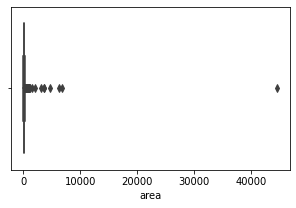

In [35]:
make_box_plot(df, cols=['area'])

In [36]:
maxArea = df['area'].max()
print('Maximum building area is {}'.format(maxArea))
maxIndex = df.loc[df['area']==maxArea].index
print('There is {} record with maximum area'.format(len(maxIndex)))
df.drop(maxIndex, axis=0, inplace=True)
df.reset_index(inplace=True, drop=True)

Maximum building area is 44515.0
There is 1 record with maximum area


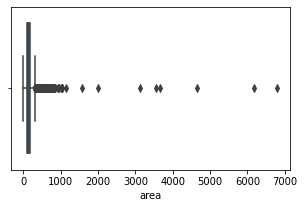

In [19]:
make_box_plot(df, cols=['area'])

There are 12 records with building area more than 1000 meter square


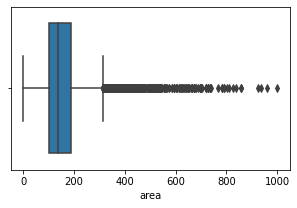

In [37]:
tempIndex = df[df['area']>1000].index
print('There are {} records with building area more than 1000 meter square'.format(len(tempIndex)))

# Still we have 8 records where the value of are is too far from the rest of data.
df.drop(tempIndex, axis=0, inplace=True)
df.reset_index(inplace=True, drop=True)
make_box_plot(df, cols=['area'])

In [38]:
df.shape

(34843, 21)

In [39]:
# It seems that the minimum value of building area is too small.
# Let us check it.
tempIndex = df[df['area']==0].index
print('There are {} building that the area is "ZERO"!'.format(len(tempIndex)))


tempIndex = df[df['area']<10].index
print('There are {} building that the area is less than 5 meter square.'.format(len(tempIndex)))

There are 76 building that the area is "ZERO"!
There are 149 building that the area is less than 5 meter square.


### Strange value of area feature:
**Records with zero building area:**
- Some records have zero area.
- One of possibility is that they are non-constructed land.
- However, they have number of room and bathroom. 
- Under this circumstances, it is more likely that data is incorrectly collected.

**Records with too small building area:**
- One idea is that they can be a commercial unit not residential units.
- But the dataset only includes residential units. 
- We will consider them as missing value and then impute them.

In [40]:
imputIndex = df.loc[df['area']<10, 'area'].index
df.loc[df['area']<10, 'area'] = np.nan

In [41]:
df.loc[imputIndex, 'area'].head(5)

278    NaN
467    NaN
1139   NaN
1650   NaN
1902   NaN
Name: area, dtype: float64

In [42]:
df.corr()['area']

room          0.645333
price         0.513095
distance      0.145575
postcode      0.090624
bathroom      0.599632
parking       0.349736
landsize      0.096638
area          1.000000
yearbuilt     0.084885
lattitude    -0.048531
longtitude    0.105425
count        -0.050860
misscnt       0.103877
Name: area, dtype: float64

### Good Points:
- Area feature has pretty high correlation with room feature.
- We can take advantage of this correlation to impute the area features.
- Room number is ordinal and area is continuous variable.

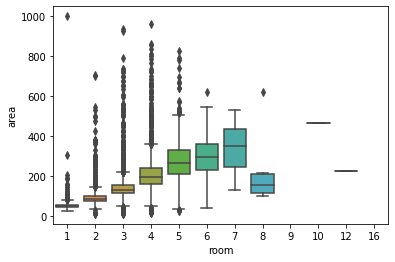

In [43]:
sns.boxplot(df['room'], df['area']);

### Insights:
- The general behavior of rooms vs area is logical till records with 8 rooms.
- Records with rooms beyond 8 rooms are not in harmony with the rest.
- **Some Issues:**
    - The average of records with 8 rooms is less than records with 4 rooms.
    - The average of records with 12 rooms is less than records with 5 rooms.
    - In fact, it should be a logical problem in data entry. It really does not make sense that area of record with 8 rooms be less than record with 4 rooms.
- We can check number of records with this problem. If the numebr is not a lot, we can delete them.
- Let's check it.

In [44]:
np.count_nonzero(df['room']>7)

33

In [45]:
# We will remove records with room more than 7:
dropIndex = df.loc[df['room']>7].index
df.drop(dropIndex, axis=0, inplace=True)
df.reset_index(inplace=True, drop=True)
print('{} recorde with more than 7 rooms are deleted.'.format(len(dropIndex)))

33 recorde with more than 7 rooms are deleted.


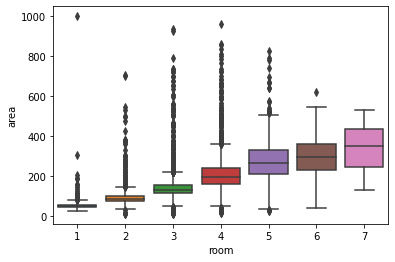

In [46]:
sns.boxplot(df['room'], df['area']);

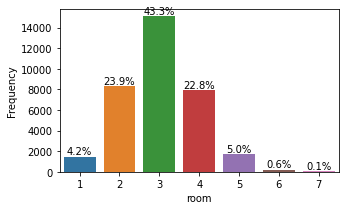

In [47]:
make_count_plot(df, cols=['room'], annotate=True, xRotation = 0, title=None)

In [49]:
# making a backup:
df3 = df.copy(deep = True)

#df = df3.copy(deep = True)

In [50]:
# We measure the mean area for properties with different count of room. 
roomLst = sorted(df['room'].unique())
areaLst = [round(df.loc[df['room']==room, 'area'].mean()) for room in roomLst]

print(roomLst)
print(areaLst)

[1, 2, 3, 4, 5, 6, 7]
[55.0, 92.0, 141.0, 209.0, 278.0, 297.0, 334.0]


In [51]:
# areaLst has 7 cells:
# The cell number 1 is mean area for property with one room,
# The cell number 2 is mean area for property with two room, and etc.
# So we can pass the number of room as a counter to the array.

imputIndex = df.loc[df['area'].isnull()].index
imputRes = [areaLst[df.loc[index, 'room'] - 1]  for index in imputIndex]
df.loc[imputIndex, 'area'] = imputRes
print('The area feature in {} records are imputed.'.format(len(imputIndex)))

# The following for loop is slow:
# for index in imputIndex:
#     i = df.loc[index, 'room']
#     df.loc[index, 'area'] = areaLst[i-1] 

The area feature in 21239 records are imputed.


In [52]:
df['area'].isnull().sum()

0

In [53]:
# making a backup:
df4 = df.copy(deep = True)

#df = df4.copy(deep = True)

## Checking Feature "yearbuilt":

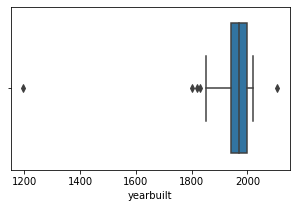

In [54]:
make_box_plot(df, cols=['yearbuilt'])

In [56]:
minYear = df['yearbuilt'].min()
maxYear = df['yearbuilt'].max()
print('Minimum yerabuilt: {}'.format(minYear))
print('Maximum yerabuilt: {}'.format(maxYear))

Minimum yerabuilt: 1196.0
Maximum yerabuilt: 2106.0


In [57]:
dropIndex = df.loc[(df['yearbuilt']== minYear) | (df['yearbuilt']== maxYear)].index
df.drop(dropIndex, axis=0, inplace=True)
df.reset_index(inplace=True, drop=True)

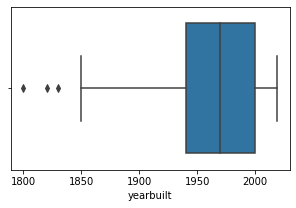

In [58]:
make_box_plot(df, cols=['yearbuilt'])

In [59]:
df.corr()['yearbuilt']

room         -0.014751
price        -0.339654
distance      0.328269
postcode      0.091328
bathroom      0.168586
parking       0.133914
landsize      0.045534
area          0.058202
yearbuilt     1.000000
lattitude     0.091646
longtitude   -0.021340
count         0.025073
misscnt      -0.012810
Name: yearbuilt, dtype: float64

### Points:
- This feature has more than 55% of miss values.
- It is one of the candidates for dropping.
- However, it makes sense to keep it since its correlation with target variable is about 0.33
- According to the correlation with distance, it is easier to consider the relation between yearbuilt and suburb. (Since the suburb is categorical)
- The second correlated feature is bathroom.
- We will consider both of suburb and bathromm for imputing.

### Checking the subrub vs yearbuilt:

In [60]:
suburbLst = df['suburb'].unique()
print(len(suburbLst))

351


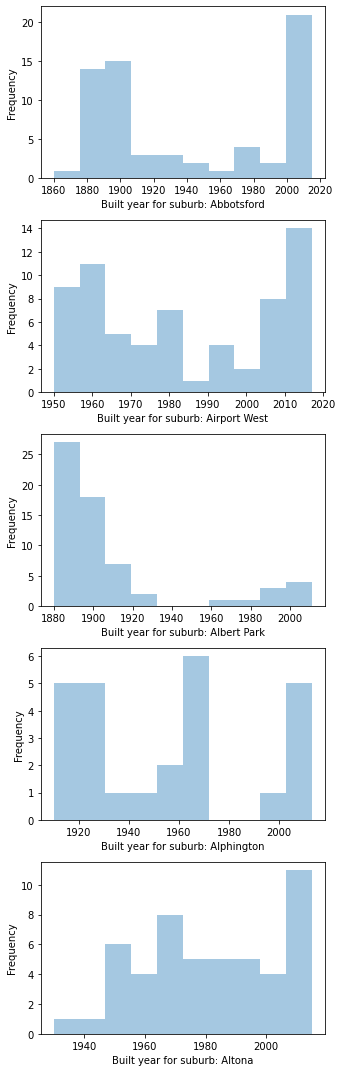

In [61]:
fig, axes = plt.subplots(5,1,figsize=(5,3*5))

for i, sub in enumerate(suburbLst[:5]):
    sns.distplot(df.loc[df['suburb']==sub, 'yearbuilt'],kde=False,bins=10, ax=axes[i]);
    axes[i].set_xlabel('Built year for suburb: {}'.format(sub))
    axes[i].set_ylabel('Frequency')
fig.tight_layout()

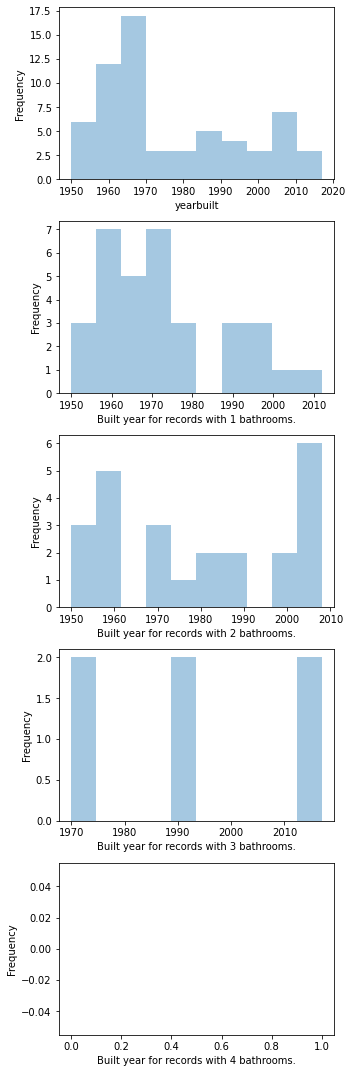

In [62]:
fig, axes = plt.subplots(5,1,figsize=(5,3*5))

# We will check one suburb just for presenting purposes.
temp_df = df.loc[df['suburb']==suburbLst[10]]
sns.distplot(temp_df['yearbuilt'],kde=False,bins=10, ax=axes[0]);
axes[0].set_ylabel('Frequency')

for i in range(1, 5):
    sns.distplot(temp_df.loc[temp_df['bathroom']==i, 'yearbuilt'],kde=False,bins=10, ax=axes[i]);
    axes[i].set_xlabel('Built year for records with {} bathrooms.'.format(i))
    axes[i].set_ylabel('Frequency')
fig.tight_layout()

### Insights:
- Its clear that different suburb have records with different yearbuilt.
- In addition, the relation betwen the bathroom and yearbuilt is observable.
- We will use these two to impute yearbuilt.
- Before that let us check the bathroom feature.

**Checking bathroom feature:**
- It shows that we have some nan values in bathroom feature.
- Firstly, we should take care of them.
- Besides, there are some records with **zero bathroom**.
    - Three different possibilities:
        - They are commercial units that use common bathrooms.
        - They are unconstructed land.
        - They are collected by mistake.
    - But dataset is only for residential units; The assumption of commercial units are not acceptable.
    - All of these records have number of rooms plus the fact that the type of the homes are recorded; The assumption of unconstructed land is not acceptable.
    - We can assume that they are very old homes that use common bathrooms.
    - But the built year is missed. We cannot check this hypothesis.
    - Probably they are collected by mistake. 
        - In this case we can replace zero value by nan and then impute them.

In [63]:
sorted(df['bathroom'].unique())

[0.0, 1.0, 2.0, nan, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 12.0]

In [64]:
df.loc[df['bathroom'] == 0].head()

,suburb,address,room,type,price,method,seller,date,distance,postcode,bathroom,parking,landsize,area,yearbuilt,councilarea,lattitude,longtitude,region,count,misscnt
228,Alphington,6 Naroon Rd,3,h,1485000.0,SP,McGrath,28/08/2016,6.4,3078.0,0.0,0.0,597.0,141.0,NaN,Darebin City Council,-37.7781,145.0284,Northern Metropolitan,2211.0,2
481,Armadale,3/50 Denbigh Rd,2,u,546000.0,SP,hockingstuart,30/07/2016,6.3,3143.0,0.0,0.0,0.0,92.0,NaN,Stonnington City Council,-37.8568,145.0161,Southern Metropolitan,4836.0,2
844,Balaclava,5/11 Albion St,2,u,497500.0,PI,hockingstuart,28/08/2016,6.6,3183.0,0.0,0.0,0.0,92.0,NaN,Port Phillip City Council,-37.8739,144.9929,Southern Metropolitan,2952.0,2
1008,Balwyn,5 Shrimpton Ct,2,h,1010000.0,PI,Marshall,30/07/2016,9.7,3103.0,0.0,0.0,1611.0,92.0,NaN,Boroondara City Council,-37.8092,145.1016,Southern Metropolitan,5682.0,2
1548,Bentleigh East,579 Warrigal Rd,3,h,700000.0,S,Thomson,22/05/2016,13.9,3165.0,0.0,0.0,456.0,141.0,NaN,Glen Eira City Council,-37.9314,145.0808,Southern Metropolitan,10969.0,2


In [65]:
zeroIndex = df.loc[df['bathroom']==0].index
df.loc[df['bathroom']==0, 'bathroom'] = np.nan

### Imputing Bathroom:
- Firstly, the most correlated feature should be found.
- They are room and building area.
- Both of relationships are reasonable.
- The larger building area, the more rooms and the more bathrooms.
- Based on rooms and building area we will impute bathrooms.

In [66]:
corrs = df.corr()['bathroom']
corrs

room          0.609331
price         0.430972
distance      0.123238
postcode      0.119562
bathroom      1.000000
parking       0.300036
landsize      0.034496
area          0.587356
yearbuilt     0.168585
lattitude    -0.061190
longtitude    0.106315
count        -0.032462
misscnt      -0.038582
Name: bathroom, dtype: float64

In [67]:
# Making a backup
df5 = df.copy(deep = True)

#df=df5.copy(deep=True)

In [82]:
df5.shape

(34808, 21)

In [68]:
# Finding index of rows with null bathroom.
bathIndex = df.loc[df['bathroom'].isnull()==True].index
len(bathIndex)

8262

**Question: Is there meaningful relation between home type and bathroom?**
- What about the relation between home type and number of bathroom?
- The cross table shows it is not useful, since the most frquency is only one or two.

In [69]:
table = pd.crosstab(df['type'], df['bathroom'])
table
# It is not useful, since the most frquecy is only one or two.

bathroom,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,12.0
type,,,,,,,,,
h,9017,9071,1930,251,75,14,3,1,1
t,514,1195,213,12,0,0,0,0,0
u,3431,791,25,2,0,0,0,0,0


### Imputing bathroom based on room and area:
- **room:** is ordinal feature.
- **area:** is numerical feature.
    - It is easier to classify it by feature bucketing.
    - First, we will plot the area then classify it.
        - According to the plot, beyond area of 300 we have very few records.
        - We will consider those value as a single subclass.

### Data binning of area feature:

<AxesSubplot:>

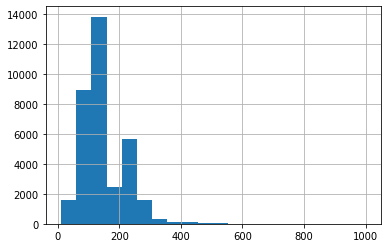

In [70]:
df['area'].hist(bins=20)

In [71]:
df['area_cut']=pd.cut(df.loc[df['area']<350, 'area'], bins=14, labels=False)
df.loc[df['area']>=350, 'area_cut'] = 14
df['area_cut'] = df['area_cut'].astype(int)
df['area_cut'].value_counts().sort_index()

0       104
1      1490
2      1216
3      7526
4      2560
5     11281
6      1407
7      1102
8      5129
9       557
10      399
11     1255
12      203
13      160
14      419
Name: area_cut, dtype: int64

In [72]:
# Making a backup
df6 = df.copy(deep = True)

#df=df6.copy(deep=True)

In [83]:
df6.shape

(34808, 22)

In [73]:
roomUniq = np.sort(df['room'].unique())
areaUniq = np.sort(df['area_cut'].unique())


# In some cases we do not have any data for some subsections.
# For those cases, we will use the most frequent number of bathroom only based on room:
bathModefromRoom = [0]*len(roomUniq)
for i, room in enumerate(roomUniq):
    bathModefromRoom[i] =  df.loc[(df['room']==room), 'bathroom'].mode(0)[0]

bathModefromRoom    

[1.0, 1.0, 1.0, 2.0, 3.0, 3.0, 3.0]

In [75]:
# Making a dataframe for : room, area_cut and bathroom:
temp_df = pd.DataFrame(columns=['room', 'area_cut', 'bathroom_mode'])

# Filling dataframe based on factorial design; Using multiple for loop inside list comprehensive.
roomLst = [room for room in roomUniq for area in areaUniq]
areaLst = [area for room in roomUniq for area in areaUniq]
temp_df['room'] = roomLst
temp_df['area_cut'] = areaLst

bathLst = [0]*len(roomLst)

# We have to calculate the most frequent bathroom for a given room and area_cut.
# Using list comprehensive(The following line) has a difficulty of exception, when there is no data for a given subsection.
# bathLst = [df.loc[(df['room']==room) & (df['area_cut']==area), 'bathroom'].mode(0) for room in roomUniq for area in areaUniq]
# Because of that matter it is preferable to apply C language format for loop:
counter = 0
for room in roomUniq:
    for area in areaUniq:
        try:
            bathLst[counter]= df.loc[(df['room']==room) & (df['area_cut']==area), 'bathroom'].mode(0)[0]
        except:
            # When there is no data for the current subsection, we will use mode only based on room. 
            bathLst[counter]= bathModefromRoom[room-1]
        counter +=1    
        
temp_df['bathroom_mode'] = bathLst
temp_df.head(5)

,room,area_cut,bathroom_mode
0,1,0,1.0
1,1,1,1.0
2,1,2,1.0
3,1,3,1.0
4,1,4,1.0


In [76]:
# Now, we can impute nan values of bathroom:
# Finding index of rows with null bathroom.
bathIndex = df.loc[df['bathroom'].isnull()==True].index

res = [temp_df.loc[(temp_df['room']==df.loc[index, 'room']) & 
                   (temp_df['area_cut']==df.loc[index, 'area_cut']), 'bathroom_mode'].values[0] for index in bathIndex]

#Updating Bathroom:
df.loc[bathIndex, 'bathroom'] = res

In [84]:
# Making a backup
df7 = df.copy(deep = True)

#df=df7.copy(deep=True)

In [85]:
df['bathroom'].isnull().sum()

0

In [86]:
df.loc[df['yearbuilt'].isnull()==True].head(2)

,suburb,address,room,type,price,method,seller,date,distance,postcode,bathroom,parking,landsize,area,yearbuilt,councilarea,lattitude,longtitude,region,count,misscnt,area_cut
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,1.0,1.0,126.0,92.0,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0,3,3
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,1.0,1.0,202.0,92.0,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0,2,3


In [87]:
imputIndex = df.loc[df['yearbuilt'].isnull()==True].index
temp_df = df.loc[df['yearbuilt'].isnull()==False]
subLst = df.loc[imputIndex, 'suburb'].values
bathLst = df.loc[imputIndex, 'bathroom'].values

# The following list comprehensive will cause some exception when there is no data in the subsection.
#res = [temp_df.loc[(temp_df['suburb']==df.loc[index, 'suburb']) & (temp_df['bathroom']==df.loc[index, 'bathroom']), 'yearbuilt'].mode(0) for index in imputIndex]

yearLst = [0]*len(imputIndex)
for i, index in enumerate(imputIndex):
    try:
        yearLst[i] = temp_df.loc[(temp_df['suburb']==subLst[i]) & (temp_df['bathroom']==bathLst[i]), 'yearbuilt'].mode(0)[0]
    except:    
        try:
            yearLst[i] = temp_df.loc[(temp_df['suburb']==subLst[i]), 'yearbuilt'].mode(0)[0]
        except:
            yearLst[i] = temp_df.loc[(temp_df['bathroom']==bathLst[i]), 'yearbuilt'].mode(0)[0]

In [88]:
# Updating yearbuilt:
df.loc[imputIndex, 'yearbuilt'] = yearLst
df['yearbuilt'].isnull().sum()

0

In [196]:
Years after 2018: pish forush
    Years after 2018: pish forush
        Years after 2018: pish forush
#print(df.shape)
#dropIndex = df.loc[df['yearbuilt']>2018].index
#df.drop(dropIndex, axis=0, inplace=True)
#df.reset_index()
#print(df.shape)

(27003, 20)
(27002, 20)


In [89]:
# Making a backup
df8 = df.copy(deep = True)

#df=df8.copy(deep=True)

19277

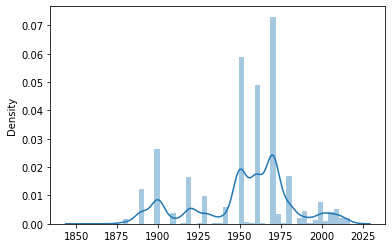

In [90]:
sns.distplot(yearLst)
len(yearLst)

In [91]:
miss_df = miss_value_func(in_data=df, classificatio_flag=0, only_miss_col=1)
miss_df

The input data frame has 22 features.
The data frame has 10 columns with missing values


,miss_value,percentage
landsize,11795,33.885888
parking,8716,25.040221
longtitude,7971,22.899908
lattitude,7971,22.899908
price,7594,21.816824
count,3,0.008619
region,3,0.008619
councilarea,3,0.008619
distance,1,0.002873
postcode,1,0.002873


In [92]:
df.shape

(34808, 22)

### Imputing Landsize:

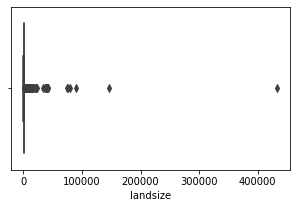

In [93]:
make_box_plot(df, cols=['landsize'])

**Landsize and Outliers:**
- Clearly, we have some outliers,
- One of the options for treatment is applying interquartile filtering.
- By the way, the outlier is mostly one sided where we have records with very large landsize.
- Different value of coefficient of IQR leads to dropping different number of records:
- The standard of IQR=1.5:
    - upper value:1300, and will drop 622 records,
- A coarser value of IQR=3:
    - upper value:2000, and will drop 357 records,
- A coarser value of IQR=4:
    - upper value:2450, and will drop 273 records,
- A coarser value of IQR=5:
    - upper value:2900, and will drop 230 records,
    
- We try to be quite conservative in deleting rows by considering **IQR coefficient of 4**.
- We ignore the records with **landsize larger than 2450**.
 

In [94]:
nIQR = 4

q1 = df['landsize'].quantile(.25)
q3 = df['landsize'].quantile(.75)
iqr = q3 - q1
lower = (q1 - nIQR * iqr)
upper = (q3 + nIQR * iqr)

upper

2454.0

In [95]:
dropIndex = df.loc[df['landsize']>2450].index
print('By filtering Landsize, {} of recrds will be deleted.'.format(len(dropIndex)))

#Updating dataframe:
df.drop(dropIndex, axis=0, inplace=True)
df.reset_index(inplace=True, drop=True)

By filtering Landsize, 273 of recrds will be deleted.


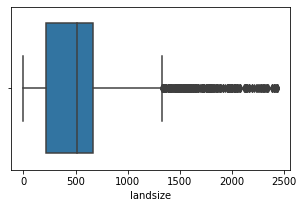

In [96]:
make_box_plot(df, cols=['landsize'])

In [97]:
df['landsize'].isnull().sum()

11795

In [98]:
df.loc[df['landsize']==0].shape[0]

2435

### Insights:
- 2435 records have **zero landsize**
- One possibility is that they are records with zero lot size,
- Another possibility is that dataset ignores the landsize for records located in tower.
- Of course, one possibility is that they are collected by mistake.
- In real case, it is definitely beneficial to discuss this issue with data provider.
- For now, we keep them as they are.
- By the way, we should be aware of the fact that landsize is a **numerical variable**. Under this circumstance, considering a **noticeable portion of them as Zero**, do not have positive impact on the predictablity of final model. Because model trys to find the possible impact of landsize n price while noticeable portion of numerical data is considered zero.

In [99]:
df.loc[df['landsize']==0].describe()

,room,price,distance,postcode,bathroom,parking,landsize,area,yearbuilt,lattitude,longtitude,count,misscnt,area_cut
count,2435.000000,1.940000e+03,2435.000000,2435.000000,2435.000000,2435.000000,2435.0,2435.000000,2435.000000,2430.000000,2430.000000,2435.000000,2435.000000,2435.000000
mean,1.985216,6.445099e+05,6.318234,3109.542916,1.263655,1.132238,0.0,88.745795,1967.421766,-37.826299,144.988363,8224.143737,1.004517,2.755647
std,0.722757,3.568646e+05,3.506412,63.796366,0.495971,0.566607,0.0,40.037216,34.624811,0.049484,0.053909,4114.538334,0.994015,1.642894
min,1.000000,8.500000e+04,0.000000,3000.000000,1.000000,0.000000,0.0,10.000000,1850.000000,-38.132750,144.740420,394.000000,0.000000,0.000000
25%,2.000000,4.337500e+05,3.700000,3053.500000,1.000000,1.000000,0.0,60.000000,1960.000000,-37.857300,144.955915,5058.000000,0.000000,2.000000
50%,2.000000,5.600000e+05,5.900000,3122.000000,1.000000,1.000000,0.0,92.000000,1970.000000,-37.828000,144.991150,7570.000000,1.000000,3.000000
75%,2.000000,7.400000e+05,8.000000,3163.000000,1.000000,1.000000,0.0,92.000000,2000.000000,-37.794100,145.021000,10774.000000,2.000000,3.000000
max,6.000000,3.900000e+06,38.000000,3207.000000,7.000000,7.000000,0.0,700.000000,2017.000000,-37.684100,145.288860,21650.000000,5.000000,14.000000


In [100]:
df.corr()['landsize']

room          0.415778
price         0.256782
distance      0.349758
postcode      0.091120
bathroom      0.201398
parking       0.334721
landsize      1.000000
area          0.357743
yearbuilt     0.041977
lattitude     0.003801
longtitude    0.166182
count        -0.036031
misscnt       0.070324
area_cut      0.383045
Name: landsize, dtype: float64

In [101]:
land_df = df[['area', 'area_cut', 'room', 'landsize']]
land_df.head(3)

,area,area_cut,room,landsize
0,92.0,3,2,126.0
1,92.0,3,2,202.0
2,79.0,2,2,156.0


In [102]:
print(land_df.shape)
print(df.shape)

(34535, 4)
(34535, 22)


In [103]:
df[['room', 'area']].isnull().sum()

room    0
area    0
dtype: int64

In [104]:
trainIndex = land_df.loc[land_df['landsize'].isnull()==False].index
predIndex = land_df.loc[land_df['landsize'].isnull()==True].index

In [105]:
print('Number of data for training: {}'.format(len(trainIndex)))
print('Number of data for prediction of land: {}'.format(len(predIndex)))

Number of data for training: 22740
Number of data for prediction of land: 11795


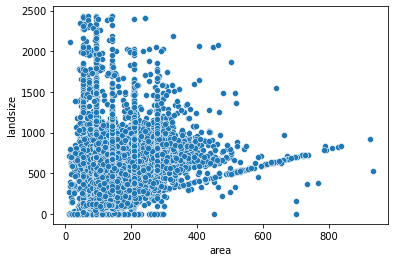

In [106]:
sns.scatterplot(df['area'], df['landsize']);

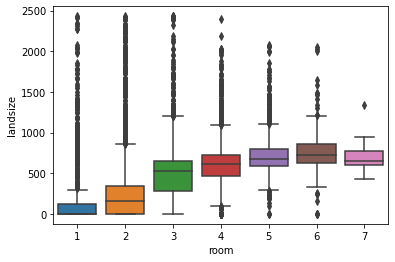

In [107]:
sns.boxplot(df['room'], df['landsize']);

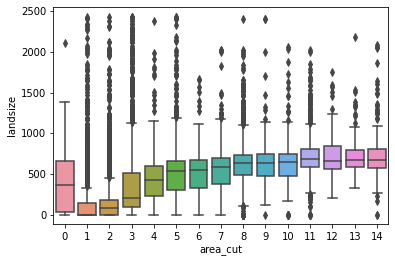

In [108]:
sns.boxplot(df['area_cut'], df['landsize']);

In [109]:
models = pd.DataFrame(index= ['R2', 'RMSE'], columns=['LR', 'RF', 'XGB'])
models

,LR,RF,XGB
R2,NaN,NaN,NaN
RMSE,NaN,NaN,NaN


In [114]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [124]:
X= land_df.loc[trainIndex, ['area', 'room']]
y = land_df.loc[trainIndex, 'landsize']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [125]:
model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)

analyze_prediction(preds, y_test, result_matrix = models, model_name='LR')

R2, RMSE:


(0.17006308476585374, 297.4122609791711)

In [126]:
model = RandomForestRegressor(random_state= 123)
model.fit(X_train, y_train)
preds = model.predict(X_test)

analyze_prediction(preds, y_test, result_matrix = models, model_name='RF')

R2, RMSE:


(0.13827652718171213, 303.05418725063015)

In [127]:
model = XGBRegressor()
model.fit(X_train, y_train)
preds = model.predict(X_test)

analyze_prediction(preds, y_test, result_matrix = models, model_name='XGB')

R2, RMSE:


(0.1570546673959371, 299.73401597443547)

In [119]:
models

,LR,RF,XGB
R2,0.170063,0.138277,0.157055
RMSE,297.412,303.054,299.734


### Insights:
- The results of evaluation metrics is not interesting.
- This issue can be confirmed by checking the scatter plot.
- Is it better to contnue with only median or mean imputation?

In [128]:
X= land_df.loc[trainIndex, ['area_cut', 'room']]
y = land_df.loc[trainIndex, 'landsize']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [129]:
model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)

analyze_prediction(preds, y_test, result_matrix = models, model_name='LR')

R2, RMSE:


(0.17029910600989362, 297.36996824469503)

In [130]:
model = RandomForestRegressor(random_state= 123)
model.fit(X_train, y_train)
preds = model.predict(X_test)

analyze_prediction(preds, y_test, result_matrix = models, model_name='RF')

R2, RMSE:


(0.17794730063233488, 295.9962148005965)

In [131]:
model = XGBRegressor()
model.fit(X_train, y_train)
preds = model.predict(X_test)

analyze_prediction(preds, y_test, result_matrix = models, model_name='XGB')

R2, RMSE:


(0.17750806660725604, 296.07528165776205)

In [132]:
# making a backup:
df9 = df.copy(deep=True)

#df = df9.copy(deep=True)

In [133]:
df['landsize']= df['landsize'].fillna(df['landsize'].median())

In [134]:
# making a backup:
df10 = df.copy(deep=True)

#df = df10.copy(deep=True)

### Checking Parking:

In [135]:
corrs = df.corr()['parking']
corrs

room          0.388396
price         0.196711
distance      0.234452
postcode      0.064166
bathroom      0.299036
parking       1.000000
landsize      0.314577
area          0.345095
yearbuilt     0.131091
lattitude    -0.012484
longtitude    0.049500
count        -0.005874
misscnt       0.038081
area_cut      0.369123
Name: parking, dtype: float64

In [136]:
# Finding index of rows with null bathroom.
imputIndex = df.loc[df['parking'].isnull()==True].index
len(imputIndex)

8704

In [137]:
for index in imputIndex:
    subVal = df.loc[index, 'suburb']
    roomVal = df.loc[index, 'room']
    
    try:
        # If we have only one variable to choose --> we add .to_frame() to the end of statement:
        df.loc[index, 'parking'] = df.loc[(df['suburb']== subVal) & (df['room']== roomVal), 'parking'].to_frame().mode()[0]
    except:
        # Why do we have exception:
        # When we do not have any data for the this room and suburb, there would be no mode.
        # In this case, we will impute based on the whole dataset.
        df.loc[index, 'parking'] = df.loc[df['room']==roomVal, 'parking'].mode()[0]

In [138]:
# Finding index of rows with null parking.
parkIndex = df.loc[df['parking'].isnull()==True].index
len(parkIndex)

0

In [139]:
# Updating missing data frame:
miss_df = miss_value_func(in_data=df, classificatio_flag=0, only_miss_col=1)
miss_df

The input data frame has 22 features.
The data frame has 8 columns with missing values


,miss_value,percentage
longtitude,7971,23.080932
lattitude,7971,23.080932
price,7528,21.798176
count,3,0.008687
region,3,0.008687
councilarea,3,0.008687
distance,1,0.002896
postcode,1,0.002896


In [140]:
# making a backup:
df11 = df.copy(deep=True)

#df = df11.copy(deep=True)

### Checking Distance:

In [141]:
df.loc[df['distance'].isnull()]

,suburb,address,room,type,price,method,seller,date,distance,postcode,bathroom,parking,landsize,area,yearbuilt,councilarea,lattitude,longtitude,region,count,misscnt,area_cut
29191,Fawkner Lot,1/3 Brian St,3,h,616000.0,SP,Brad,6/01/2018,NaN,NaN,1.0,2.0,512.0,141.0,1970.0,NaN,NaN,NaN,NaN,NaN,13,5


In [142]:
df.loc[df['suburb'] == 'Fawkner Lot']

,suburb,address,room,type,price,method,seller,date,distance,postcode,bathroom,parking,landsize,area,yearbuilt,councilarea,lattitude,longtitude,region,count,misscnt,area_cut
29191,Fawkner Lot,1/3 Brian St,3,h,616000.0,SP,Brad,6/01/2018,NaN,NaN,1.0,2.0,512.0,141.0,1970.0,NaN,NaN,NaN,NaN,NaN,13,5


In [143]:
# Since the above record does not have any latitude, longitude, councilarea, region, postcode, distance, we remove it.
df.dropna(subset=['distance'], inplace=True)
df.reset_index(inplace=True, drop=True)
df.shape

(34534, 22)

In [144]:
# Updating missing data frame:
miss_df = miss_value_func(in_data=df, classificatio_flag=0, only_miss_col=1)
miss_df

The input data frame has 22 features.
The data frame has 6 columns with missing values


,miss_value,percentage
longtitude,7970,23.078705
lattitude,7970,23.078705
price,7528,21.798807
count,2,0.005791
region,2,0.005791
councilarea,2,0.005791


### Checking Region

In [145]:
df.loc[df['region'].isnull()]

,suburb,address,room,type,price,method,seller,date,distance,postcode,bathroom,parking,landsize,area,yearbuilt,councilarea,lattitude,longtitude,region,count,misscnt,area_cut
18307,Footscray,2/16 Stafford St,2,u,710000.0,S,Jas,15/07/2017,5.1,3011.0,1.0,1.0,512.0,92.0,1900.0,NaN,NaN,NaN,NaN,NaN,11,3
26611,Camberwell,2/3 Kingsley St,2,h,825000.0,VB,Jellis,11/11/2017,7.7,3124.0,1.0,1.0,512.0,92.0,1960.0,NaN,NaN,NaN,NaN,NaN,11,3


### Imputing method:
- Imputing based on two features: **Suburb and Distance**
- Suburb is a subsection of region and councilarea.
    - Region and councilarea can easily be imputed based on suburb.
    
- We can impute latitude and longtitude based on distance and suburb.

In [146]:
imputIndex = df.loc[(df['suburb'] == 'Footscray') & (df['region'].isnull())].index
resData = df.loc[df['suburb'] == 'Footscray', ['councilarea', 'region', 'count']].values[0]
df.loc[imputIndex, ['councilarea', 'region', 'count']] = resData

In [147]:
imputIndex = df.loc[(df['suburb'] == 'Camberwell') & (df['region'].isnull())].index
resData = df.loc[df['suburb'] == 'Camberwell', ['councilarea', 'region', 'count']].values[0]
df.loc[imputIndex, ['councilarea', 'region', 'count']] = resData

In [148]:
# Updating missing data frame:
miss_df = miss_value_func(in_data=df, classificatio_flag=0, only_miss_col=1)
miss_df

The input data frame has 22 features.
The data frame has 3 columns with missing values


,miss_value,percentage
longtitude,7970,23.078705
lattitude,7970,23.078705
price,7528,21.798807


In [149]:
# making a backup:
df12 = df.copy(deep=True)

#df = df12.copy(deep=True)

### Imputing Lattitude and Longtitude:
- There are three levels of municiple subsections.
- We have to find the smallest subsections.
- Based on the smallest variable, we can impute the lattitude nad longtitude.

In [150]:
print(df['region'].nunique())
print(df['councilarea'].nunique())
print(df['suburb'].nunique())

8
33
344


In [151]:
df.reset_index(inplace=True, drop=True)
latIndex = df.loc[df['lattitude'].isnull()==True].index


print(len(latIndex))

7970


In [152]:
#####################
# One scenario:
# Since some subsection do not have any data, the following line will cause some exceptions:
# latitudeLst = [df.loc[(df['suburb']==df.loc[x, 'suburb']) & (df['distance']==df.loc[x, 'distance']), 'lattitude'].mode()[0] for x in latIndex]
# Because of that it is preferable to use C language format for loop.

#####################
# Another scenario:
# Suppose that the record that we want to impute it is only one record with unique distance and suburb.
# In that case there is no more data with similar distance or suburb.
# We cannot impute it based on other records with the same distance and suburb.
# We will delete them.
# For this type of record, we will save their index in remainIndex array.


remainIndex = []
for index in latIndex:
    subVal = df.loc[index, 'suburb']
    distVal = df.loc[index, 'distance']
    
    temp_df = df.loc[(df['suburb']== subVal) & (df['distance']== distVal), ['lattitude', 'longtitude']]
    try:
        df.loc[index, 'lattitude'] = temp_df['lattitude'].mode()[0]
        df.loc[index, 'longtitude'] = temp_df['longtitude'].mode()[0]
    except:
        if(temp_df.shape[0] == 1):
            remainIndex.append(index)
        else:
            temp_df = df.loc[df['distance']== distVal, ['lattitude', 'longtitude']]
            df.loc[index, 'lattitude'] = temp_df['lattitude'].mode()[0]
            df.loc[index, 'longtitude'] = temp_df['longtitude'].mode()[0]
            
remainIndex            

[15381, 18451, 22835, 26275]

In [153]:
df.shape

(34534, 22)

In [154]:
# We have to delete the remained records that are unique in distance and suburb.
df.drop(remainIndex, axis=0, inplace=True)
df.reset_index(inplace=True, drop=True)
df.shape

(34530, 22)

In [155]:
# making a backup:
df13 = df.copy(deep=True)

#df = df13.copy(deep=True)

In [156]:
# Updating missing data frame:
miss_df = miss_value_func(in_data=df, classificatio_flag=0, only_miss_col=1)
miss_df

The input data frame has 22 features.
The data frame has 1 columns with missing values


,miss_value,percentage
price,7527,21.798436


### Target feature vs missing value:
- The target is **price** column.
- The goal is prediction of price of a give home.
- Of course, we can impute price feature.
- However, it should be noted that model will be evaluated by the accuracy of price prediction.
- Because of that it is reasonable to drop rows with missing of price. 

**Question:**
- Why did not we drop them first:
- We keep them to take advantage of those data for imputing purposes.

In [157]:
df.dropna(subset=["price"], inplace=True)
df.reset_index(inplace=True, drop=True)

In [158]:
# Making a backup
df14 = df.copy(deep = True)

# df=df14.copy(deep=True)

In [159]:
# Updating missing dataframe:
miss_df = miss_value_func(in_data=df, classificatio_flag=0, only_miss_col=1)
miss_df

The input data frame has 22 features.
The data frame has 0 columns with missing values


,miss_value,percentage


In [161]:
print(df.shape)
df.drop(['misscnt', 'area_cut'], axis=1, inplace=True)
print(df.shape)

(27003, 22)
(27003, 20)


In [162]:
# Making a backup
df15 = df.copy(deep = True)

# df=df15.copy(deep=True)

### There is no more missing values!

In [163]:
metadata = make_metadata(df)

catFeatures, catCnt, cat_df = make_typedf(df, metadata, 'categorical')
ordFeatures, ordCnt, ord_df = make_typedf(df, metadata, 'ordinal')
numFeatures, numCnt, num_df = make_typedf(df, metadata, 'numeric')
binFeatures, binCnt, bin_df = make_typedf(df, metadata, 'binary')

metadata

,role,type,dtype,uniqueCnt
varname,,,,
suburb,input,categorical,object,337
address,input,categorical,object,26512
room,input,ordinal,int64,7
type,input,categorical,object,3
price,input,numeric,float64,2862
method,input,categorical,object,5
seller,input,categorical,object,349
date,input,categorical,object,78
distance,input,numeric,float64,212


### Datatype transformations:
- Transformation into **date datatype**:
    - date
- Transformation into **ordinal datatype (int)**:
    - room, bathroom, parking, yearbuilt, count 
- Transformation into **categorical datatype (object)**:
    - postcode

In [164]:
## Transforming date datatype:
df['date'] =  pd.to_datetime(df['date'])

In [165]:
cols = ['room', 'bathroom', 'parking', 'yearbuilt', 'count']
for col in cols:
    df[col] = df[col].astype(int)   

In [166]:
df['postcode'] = df['postcode'].astype('O')

In [167]:
metadata = make_metadata(df)

catFeatures, catCnt, cat_df = make_typedf(df, metadata, 'categorical')
ordFeatures, ordCnt, ord_df = make_typedf(df, metadata, 'ordinal')
numFeatures, numCnt, num_df = make_typedf(df, metadata, 'numeric')
binFeatures, binCnt, bin_df = make_typedf(df, metadata, 'binary')

In [169]:
check_numCols(df=df, cols=df.columns);
#That is fine, since they are all none numerical features

Notice!!!

The following columns are not pure numerical. They have some non-numericla data.
['suburb', 'address', 'type', 'method', 'seller', 'postcode', 'councilarea', 'region']


In [170]:
df.shape

(27003, 20)

### Outlier Analysis:

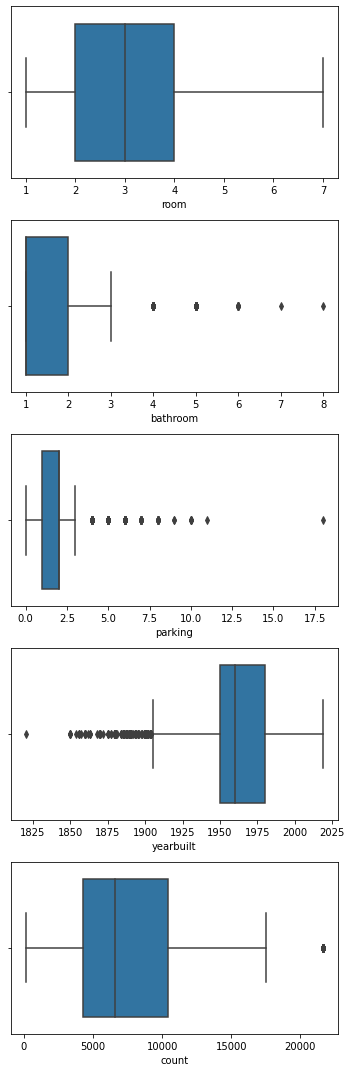

In [171]:
#removeOutliers_IQR(df, num_Feat='area', nIQR = 1.5, inplace=True ,imputation=0);
make_box_plot(df, cols=ordFeatures)

In [172]:
df['bathroom'].value_counts()

1    15624
2     9617
3     1538
4      168
5       45
6        9
8        1
7        1
Name: bathroom, dtype: int64

In [173]:
df['parking'].value_counts()

2     13367
1     10030
0      1240
3      1220
4       890
5       111
6       102
7        19
8        15
10        5
9         2
11        1
18        1
Name: parking, dtype: int64

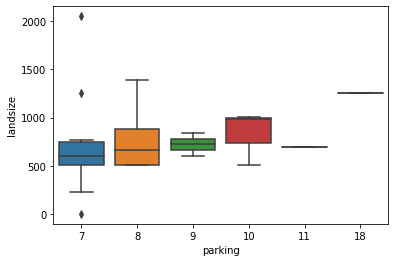

In [174]:
sns.boxplot(df.loc[df['parking']>6, 'parking'], df['landsize']);

### Insights:
- The relation between parking and landsize,
- Records that have more than 6 parking slots, have landsize more than 500 meter square.
- It is quite reasonable to keep them.

**Do we have presale transaction?**

In [175]:
df.loc[df['yearbuilt']>df['date'].dt.year].head(3)

,suburb,address,room,type,price,method,seller,date,distance,postcode,bathroom,parking,landsize,area,yearbuilt,councilarea,lattitude,longtitude,region,count
60,Airport West,33 Bowes Av,5,h,1035000.0,S,Airport,2016-06-08,13.5,3042,2,2,512.0,278.0,2017,Moonee Valley City Council,-37.7203,144.8792,Western Metropolitan,3464
61,Airport West,89 Bowes Av,4,h,960000.0,S,Barry,2016-06-08,13.5,3042,2,2,512.0,209.0,2017,Moonee Valley City Council,-37.7203,144.8792,Western Metropolitan,3464
62,Airport West,45 Laurence Av,4,h,960000.0,S,Nelson,2016-06-08,13.5,3042,2,2,512.0,209.0,2017,Moonee Valley City Council,-37.7203,144.8792,Western Metropolitan,3464


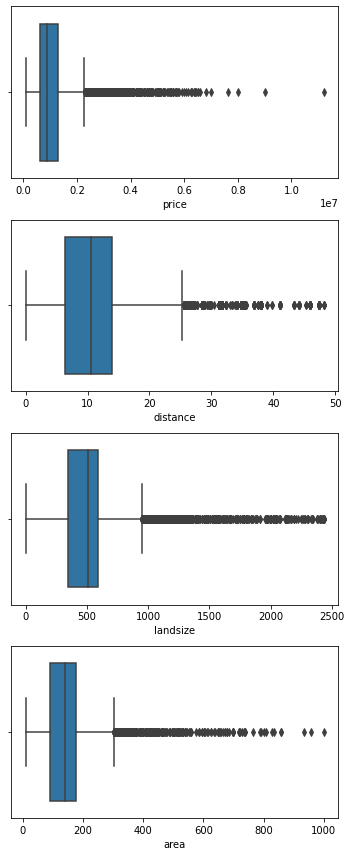

In [176]:
make_box_plot(df, cols=numFeatures[:4])

### Insights:
- The range of features are reasonable.
- We will keep them ae they are.

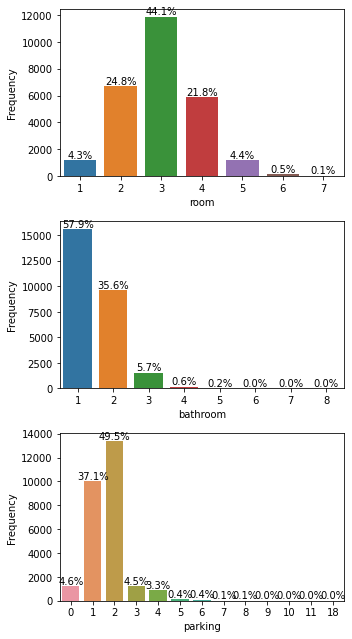

In [177]:
make_count_plot(df, cols=ordFeatures[:3], annotate=True, xRotation = 0, title=None)

### Feature Engineering:
We will make some new features:
- house age,
- month of sale,
- season of sale,
- year of sale,

In [180]:
# Making a backup:
df16 = df.copy(deep=True)

#df = df16.copy(deep=True)

In [182]:
df['age'] = 2018 - df['yearbuilt']

df['year'] = df['date'].dt.year

df['season'] = findSeason(dayLst = df['date'].dt.dayofyear)

df['month'] = df['date'].dt.month

df['period'] = df['date'].dt.to_period('M')


# Identify historic homes
df['history'] = np.where(df['age']>=50,'Old','New').astype('O')

In [183]:
df.head(1)

,suburb,address,room,type,price,method,seller,date,distance,postcode,bathroom,parking,landsize,area,yearbuilt,councilarea,lattitude,longtitude,region,count,age,year,season,month,period,history
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-03-12,2.5,3067,1,1,202.0,92.0,1900,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019,118,2016,Winter,3,2016-03,Old


In [184]:
# Making a backup:
df17 = df.copy(deep=True)

#df = df17.copy(deep=True)

**Exporting dataset for future using:**

In [185]:
df.to_csv(r'D:\my_data\Housing\Melbourne\Melbourne_Tohid.csv', index=False)

In [186]:
df111 = pd.read_csv(r"D:\my_data\Housing\Melbourne\Melbourne_Tohid.csv")
df111.head(2)

,suburb,address,room,type,price,method,seller,date,distance,postcode,bathroom,parking,landsize,area,yearbuilt,councilarea,lattitude,longtitude,region,count,age,year,season,month,period,history
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-03-12,2.5,3067.0,1,1,202.0,92.0,1900,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019,118,2016,Winter,3,2016-03,Old
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,2016-04-02,2.5,3067.0,1,0,156.0,79.0,1900,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019,118,2016,Spring,4,2016-04,Old
